In [1]:
# Base libraries
from collections import namedtuple, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable, Any
import numpy as np
import pandas as pd
import random
import pickle
import os

# ML libraries
import torch

# Local imports
from env import Env
from agents.random_agent import RandomAgent
from agents.deep_q_agent import DeepQAgent
from agents.cql_agent import CQLAgent
from agents.minimax_agent import MinimaxAgent
import utils

# Fix random seed
utils.seed_everything()

# Import Transformers
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

Episode: 0, RTG (start) : -1, length: 3, reward end: -1, done: True
Score: Agent 0 - 1 Opponent


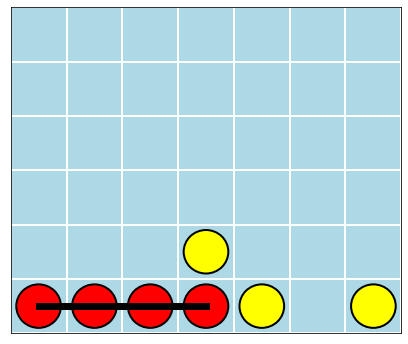

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [17]:
'''2 Options: 
        Generate Trajectories now
        Load existing Trajectories from a file
'''
GENERATE_TRAJECTORIES = True #Set if you want to load from file or generate them here

# NOTE: Filename style: {agent_name}{input_params}_vs_{opponent_name}{input_params}_num{NUM_TRAJ}.pkl
file_to_load_from = 'minimax0_2_vs_minimax0_2_num500.pkl' #Define file from where to load the trajectories
file_to_store_to = 'random100k.pkl' #Define file to where we should store the generated trajectories

AGENT = 1
OPPONENT = 2
# Number of created trajectories
NUM_TRAJ = 100000

if GENERATE_TRAJECTORIES:
    # Generate T_offline (offline Trajectories for the offline initialization of the replay buffer)
    # NOTE: alternative would be to initialize with either Random Trajs, or with Traj.s from DQN Agent / CQL Agent
    # NOTE: Corresponding paper: https://arxiv.org/pdf/2202.05607.pdf

    
    offline_trajectories = []

    #Initialize Environment and Agent
    env = Env()
    # agent = MinimaxAgent(env, depth=2, epsilon=0.2, player=1)
    # opponent = MinimaxAgent(env, depth=2, epsilon=0.2, player=2)
    agent = MinimaxAgent(env, depth=2, epsilon=1, player=1)
    opponent = MinimaxAgent(env, depth=2, epsilon=1, player=2)

    agent_won = 0
    agent_lost = 0

    for i in range(0, NUM_TRAJ):

        # Initialize other variables
        finished = -1

        #Initialize fields for trajectory
        states = []
        actions = []
        rewards = []
        dones = []

        # Make it random who gets to start the game
        # Set to true during the episode
        agent_start = random.choice([True, False])
        # Run one episode of the game
        while finished == -1:
            # Agent makes a turn
            if agent_start:
                state = env.get_state()
                #action = agent.act(state)
                action = agent.act(env.field)
                valid, reward, finished = agent.env.step(action, AGENT)
                
                #env.render_pretty()
                
                
                # Update current Trajectory
                #Flatten the state to be a 42-entry 1 dimensional array
                states.append(np.ravel(state))
                actions.append(action)
                rewards.append(reward)

                if finished != -1:
                    break

            else:
                agent_start = True

            # Opponent makes their turn
            #action = opponent.act(env.get_state_inverted())
            action = opponent.act(env.field)
            valid, _, finished = opponent.env.step(action, OPPONENT)

            if finished != -1: 
                if finished == OPPONENT:
                    #TODO this is hacky, if this happens the opponent won and we need to set the last reward for the agent..
                    rewards[-1] = -1
                break

        # The Flag if the Episode is finished is False for n-1 steps and True for the last step obviously..
        dones = ([False] * (len(rewards)-1)) + [True]
    
        assert len(states) == len(actions)
        assert len(actions) == len(rewards)
        assert len(dones) == len(rewards)
        length = len(states)
        RTGs = utils.calculate_RTG(rewards)
        traj = [length, states, actions, rewards, RTGs, dones]
        offline_trajectories.append(traj)

        #Keep track of statistics
        if finished == 1:
            agent_won+=1
        elif finished == 2:
            agent_lost+=1

        if i % NUM_TRAJ/3 == 0:
            print(f"Episode: {i}, RTG (start) : {RTGs[0]}, length: {length}, reward end: {rewards[-1]}, done: {dones[-1]}")
            print(f"Score: Agent {agent_won} - {agent_lost} Opponent")
            env.render_pretty()
            # print(traj)
        env.reset()
        if i % 100 == 0:
            print(i)
        
    # Final score
    print(f"Score: Agent {agent_won} - {agent_lost} Opponent. There were {NUM_TRAJ - agent_won - agent_lost} Ties")

    # Sort offline buffer such that the order is descending in RTGs
    # [4][0] is the first RTG of the trajectory
    sorted_offline_trajectories = sorted(offline_trajectories, key=lambda x: x[4][0], reverse = True)


    #TODO: We currently only use one side of the table for generating trajectories, we could generate twice as many by also storing the trajectories from the "enemys POV"


In [18]:
if GENERATE_TRAJECTORIES:
    # HERE WE STORE TRAJECTORIES THAT WE PRODUCED ABOVE, OR ALREADY PRODUCED EARLIER!

    #Safety mechanism, to show if this specific file we want to write to doesn't already exist, and we lose our data.
    #NOTE: just comment this check out if you want to overwrite a file..
    if os.path.exists('trajectories/' + file_to_store_to):
        raise FileExistsError(f"File {file_to_store_to} already exists!")
    
    #Create Trajectories folder if in-existent
    if not os.path.exists('trajectories'):
        os.makedirs('trajectories')
    # Store data within specified file
    with open("trajectories/" + file_to_store_to, 'wb') as f:
        pickle.dump(sorted_offline_trajectories, f)

else:
    #Check if the given file exists
    if not os.path.exists('trajectories/' + file_to_load_from):
        raise FileExistsError(f"File {file_to_load_from} doesn't exist!")
    
    #Load Trajectories from specified file:
    with open('trajectories/' + file_to_load_from, 'rb') as f:
        sorted_offline_trajectories = pickle.load(f)

In [33]:
# convert the actions inside the "sorted_offline_trajectories"
print(sorted_offline_trajectories[-1])

#test_traj = [[4, 4, [1,2,3,4]]]

for i in range(len(sorted_offline_trajectories)):
    traj = sorted_offline_trajectories[i]
    actions = traj[2]
    new_actions = []
    for a in actions:
        new_action = [0,0,0,0,0,0,0]
        new_action[a] = 1
        new_actions.append(new_action)
    sorted_offline_trajectories[i][2] = new_actions

print(sorted_offline_trajectories[-1])




[3, [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0])], [3, 3, 3], [0, 0, -1], [-1, -1, -1], [False, False, True]]
[3, [array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0])], [[0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0]], [0, 0,

In [52]:
# We have a dataset containing all the offline collected data
# Using this tutorial: https://huggingface.co/blog/train-decision-transformers
# We convert the dataset into data ready for the decision transformer
FRACTION = 0.4
N = int(FRACTION * NUM_TRAJ)
dataset = sorted_offline_trajectories[:N]
lengths = [x[0] for x in dataset]
max_episode_length = max(lengths)
print(f"Maximum Episode length: {max_episode_length}")

# Constants represent the position of the value within a trajectory-array
# trajectory structure in the dataset: traj = [length, states, actions, rewards, RTGs, dones]
LENGTH = 0
STATES = 1
ACTIONS = 2
REWARDS = 3
RTGs = 4
DONES = 5

class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 21 #subsets of the episode we use for training
    state_dim: int = 42  # size of state space
    act_dim: int = 7  # size of action space
    max_ep_len: int = 42 # max episode length in the dataset TODO: is this the correct value?
    #scale: float = 1000.0  # normalization of rewards/returns
    n_traj: int = N # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = 7
        self.state_dim = 42
        self.dataset = dataset
        self.n_traj = len(dataset)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(np.arange(self.n_traj), size=batch_size, replace=True)
        
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # Select trajectory at given index
            feature = self.dataset[int(ind)]
            #set si randomly to start somewhere in the sequence (but at least max_len steps before the end..)
            length = self.dataset[ind][LENGTH]
            if length <= self.max_len:
                si = 0
            else:
                si = random.randint(0, length - self.max_len)

            # get sequences from dataset
            s.append(np.array(feature[STATES][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature[ACTIONS][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature[REWARDS][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature[DONES][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature[REWARDS][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1)
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        # Converting
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # This is how the trajectories are returned for the transformer to learn with them
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

Maximum Episode length: 21


In [53]:
# This code is 1:1 from the Huggingface blog, don't know if the loss is correct for our usecase
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        #print(f"action_preds: {action_preds} and action_targets: {action_targets}, length: {len(action_preds)}")
        
        loss = torch.mean((action_preds - action_targets) ** 2)
        #criterion = torch.nn.CrossEntropyLoss()
        #loss = criterion(action_preds, action_targets)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [54]:
#Training Arguments
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120, # 120
    per_device_train_batch_size=64, # 64
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

# Initialize and then train the model
collator = DecisionTransformerGymDataCollator(dataset)
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

trainer.train()

  0%|          | 0/15000 [00:00<?, ?it/s]

{'loss': 0.1061, 'learning_rate': 3.3333333333333335e-05, 'epoch': 4.0}
{'loss': 0.0712, 'learning_rate': 6.666666666666667e-05, 'epoch': 8.0}
{'loss': 0.0521, 'learning_rate': 0.0001, 'epoch': 12.0}
{'loss': 0.0334, 'learning_rate': 9.62962962962963e-05, 'epoch': 16.0}
{'loss': 0.0229, 'learning_rate': 9.25925925925926e-05, 'epoch': 20.0}
{'loss': 0.0185, 'learning_rate': 8.888888888888889e-05, 'epoch': 24.0}
{'loss': 0.0158, 'learning_rate': 8.518518518518518e-05, 'epoch': 28.0}
{'loss': 0.0133, 'learning_rate': 8.148148148148148e-05, 'epoch': 32.0}
{'loss': 0.0117, 'learning_rate': 7.777777777777778e-05, 'epoch': 36.0}
{'loss': 0.0104, 'learning_rate': 7.407407407407407e-05, 'epoch': 40.0}
{'loss': 0.0094, 'learning_rate': 7.037037037037038e-05, 'epoch': 44.0}
{'loss': 0.0085, 'learning_rate': 6.666666666666667e-05, 'epoch': 48.0}
{'loss': 0.0078, 'learning_rate': 6.296296296296296e-05, 'epoch': 52.0}
{'loss': 0.0073, 'learning_rate': 5.925925925925926e-05, 'epoch': 56.0}
{'loss': 0

TrainOutput(global_step=15000, training_loss=0.015448992133140564, metrics={'train_runtime': 2699.9669, 'train_samples_per_second': 355.56, 'train_steps_per_second': 5.556, 'train_loss': 0.015448992133140564, 'epoch': 120.0})

In [ ]:
print(dataset[-1])
# traj structure: [length, states, actions, rewards, RTGs, dones]

In [55]:
# store the model trained above...
# trainer.save_model("dt_model/attempt2")

# Path to your saved model
# model_path = 'dt_model/attempt1'

# Load the model
# model = TrainableDT.from_pretrained(model_path)

In [56]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous max_len timesteps.
# This function is also directly taken from the Huggingface blog post
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )
    # print(action_preds)

    return action_preds[0, -1]

In [ ]:
# util function, given a 7 elemenent array corresponding to an action, gives the int of the corresponding taken action :)


# another util function that returns index of maximum in array



Maximum Episode Length is 21


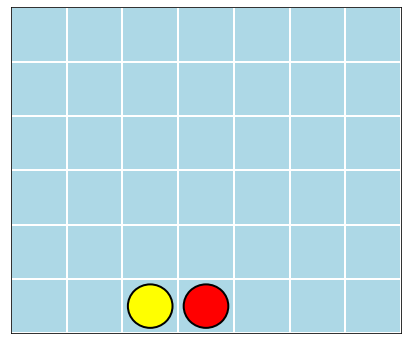

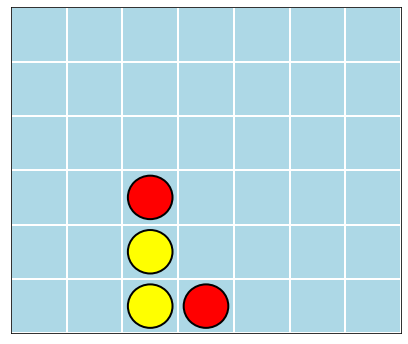

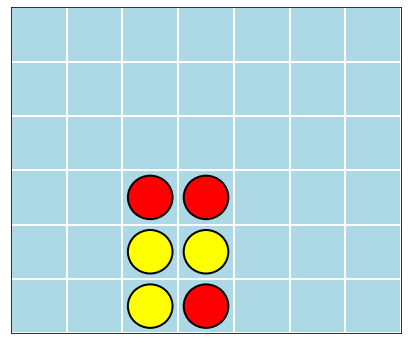

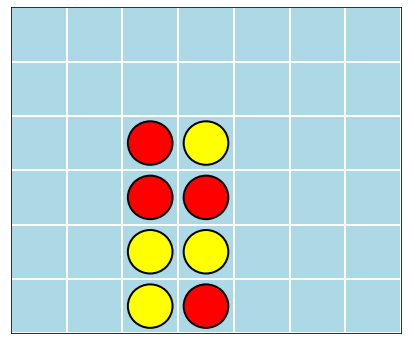

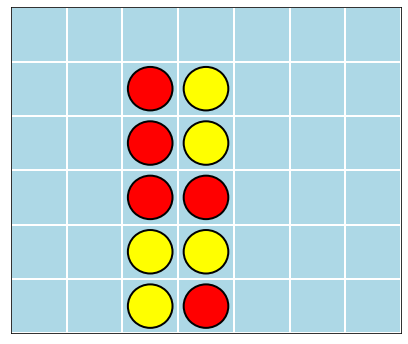

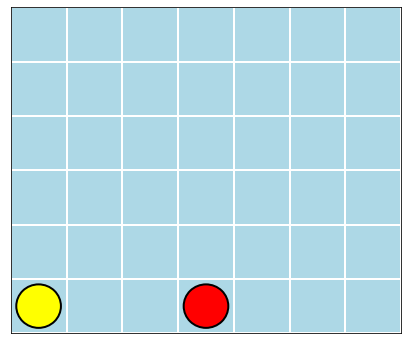

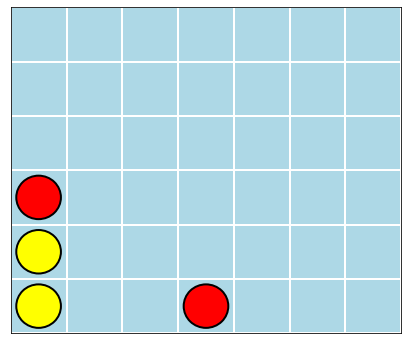

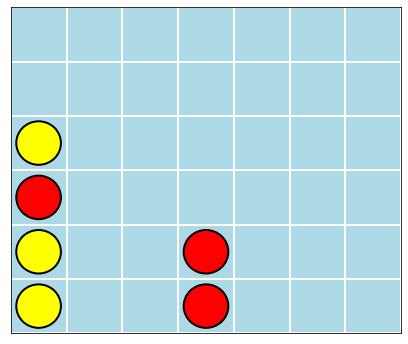

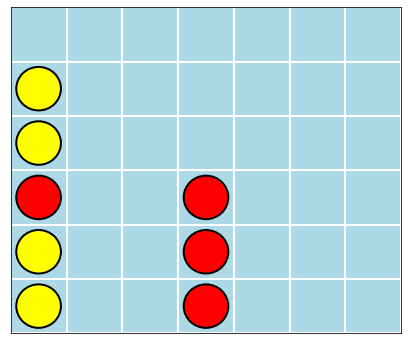

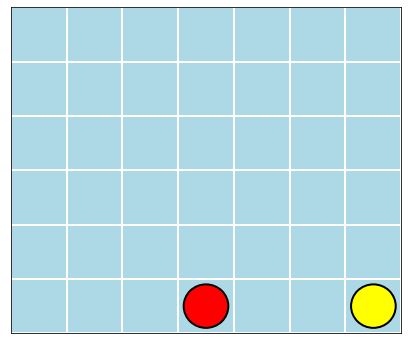

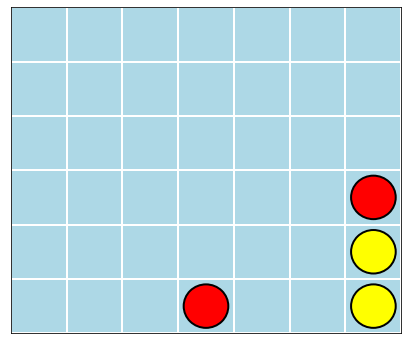

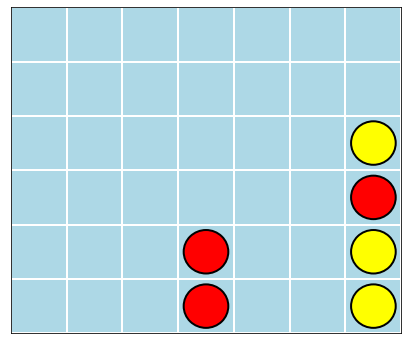

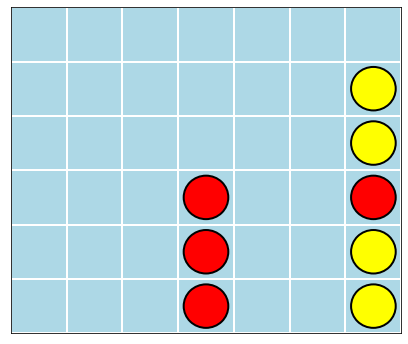

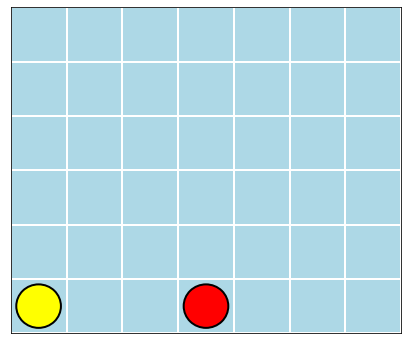

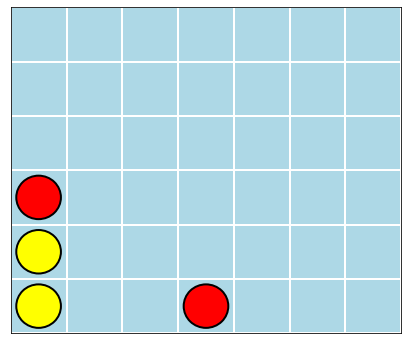

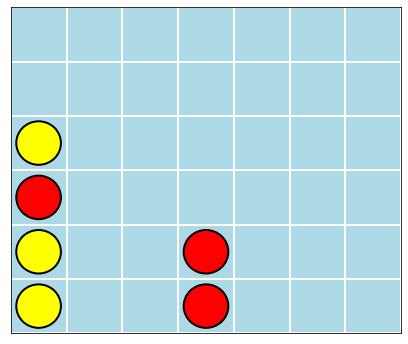

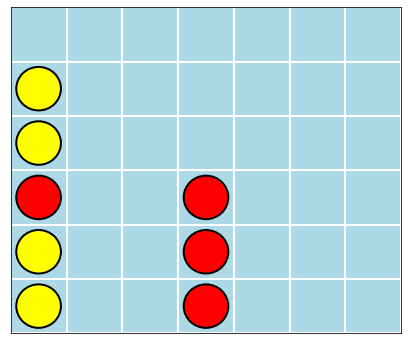

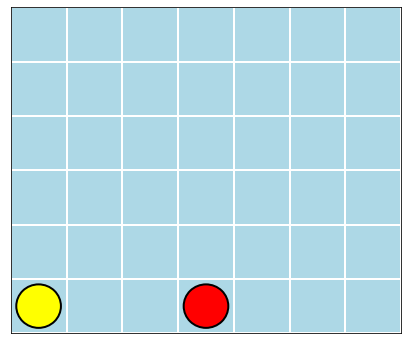

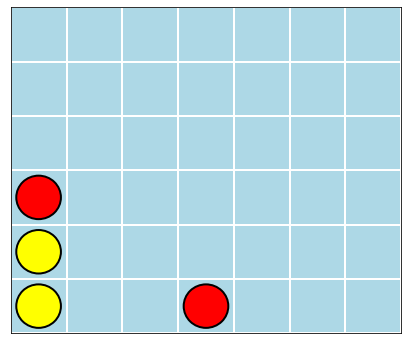

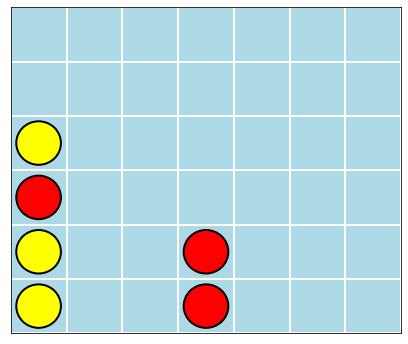

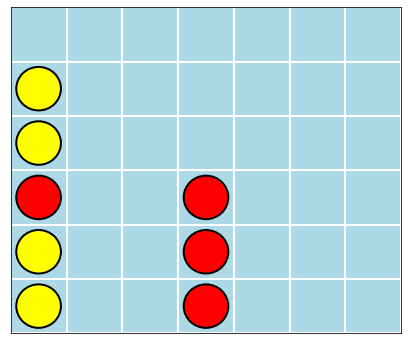

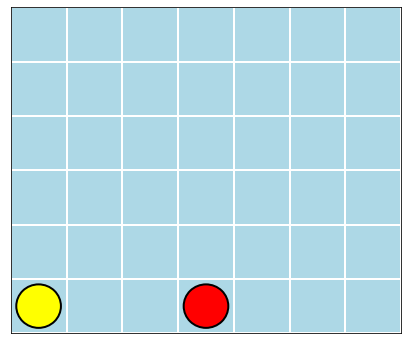

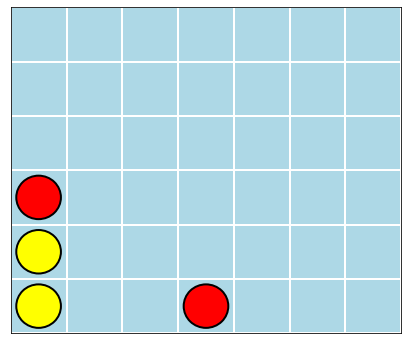

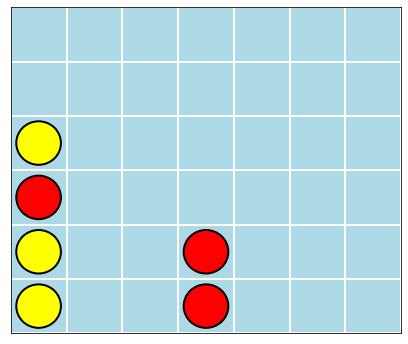

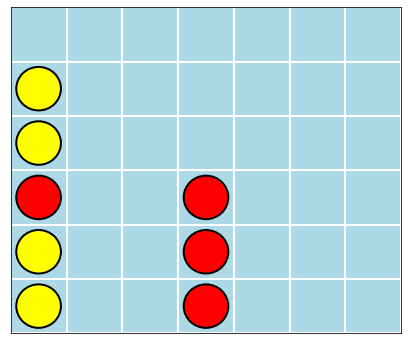

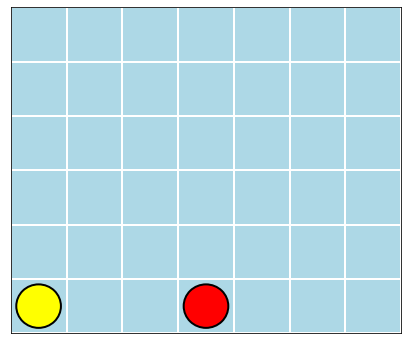

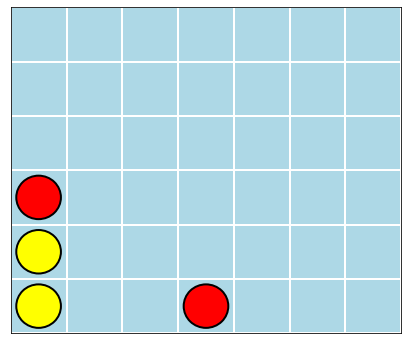

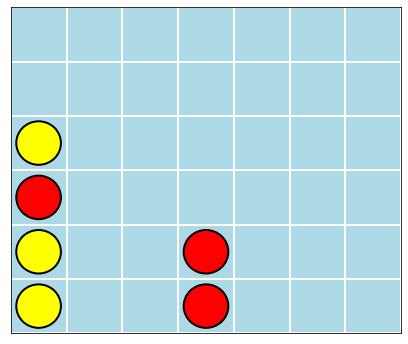

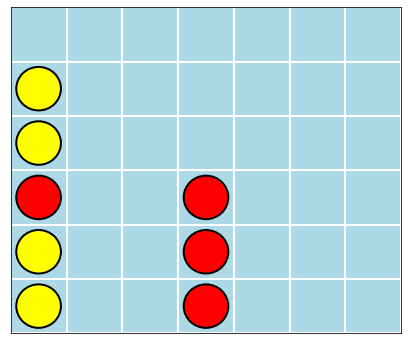

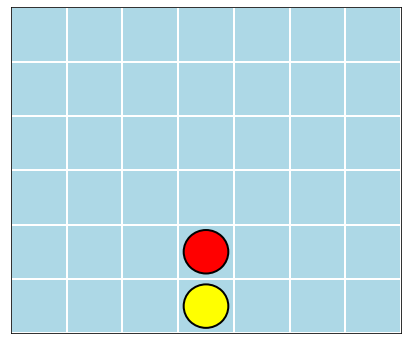

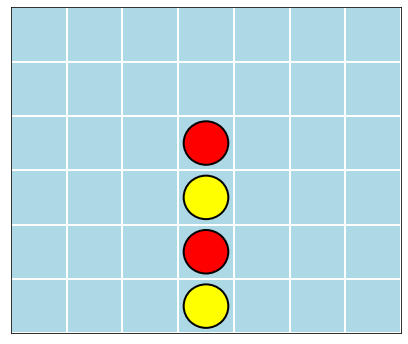

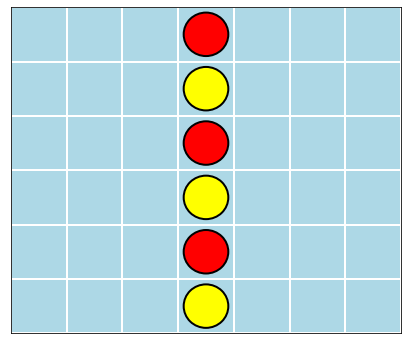

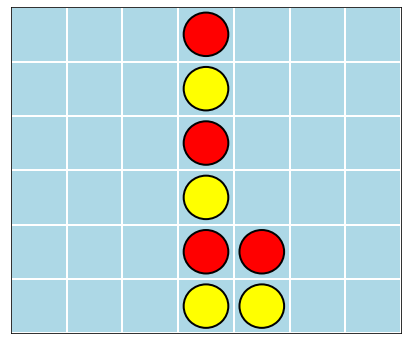

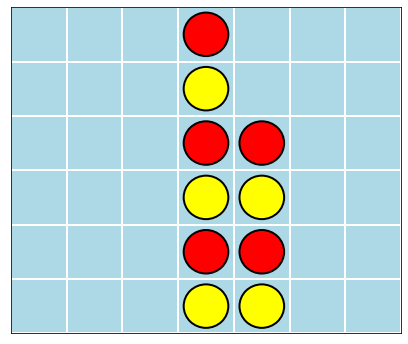

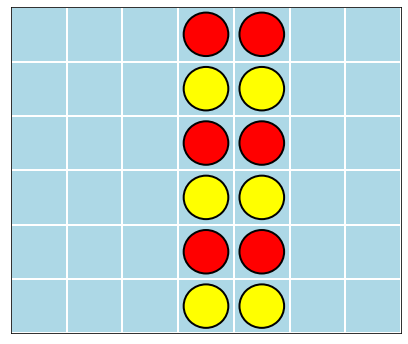

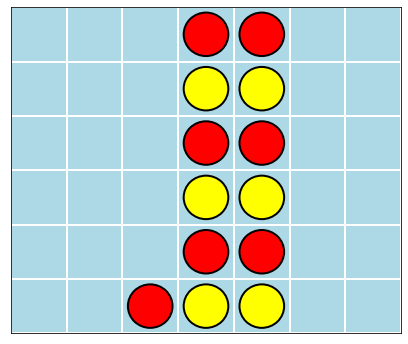

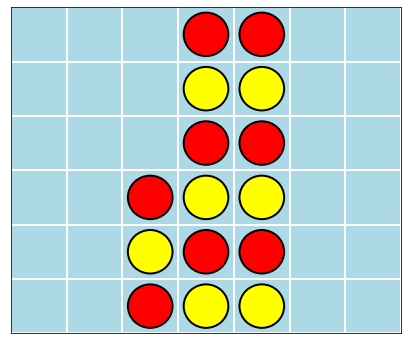

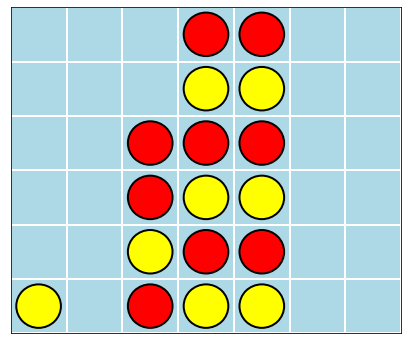

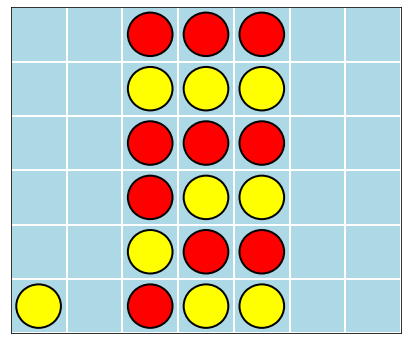

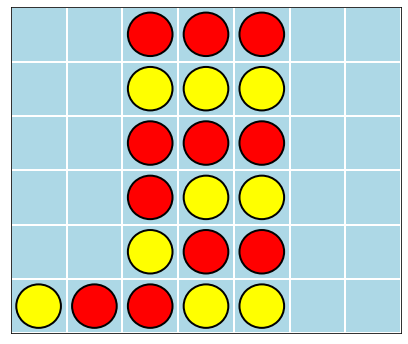

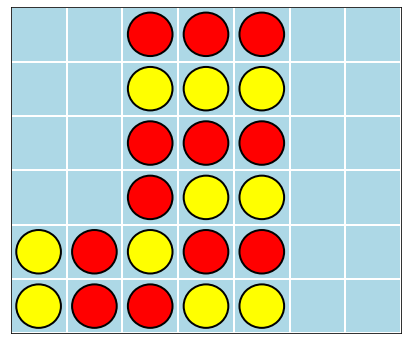

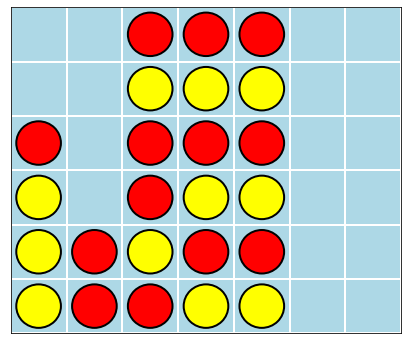

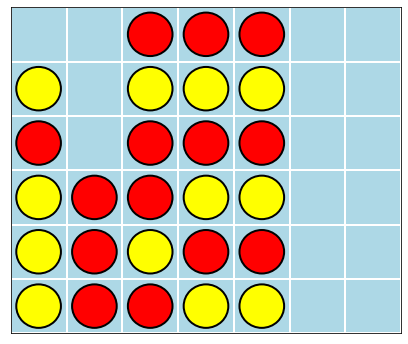

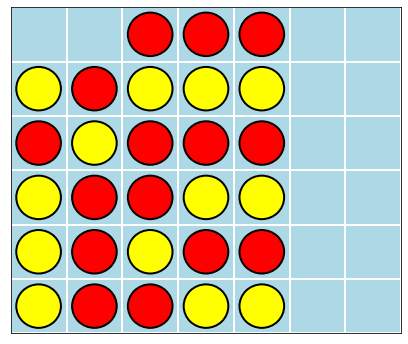

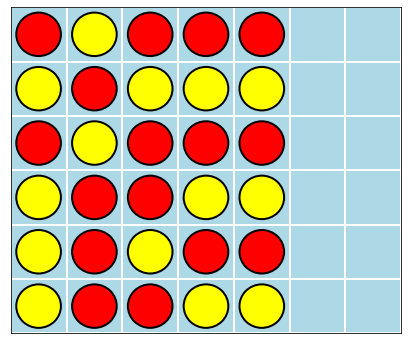

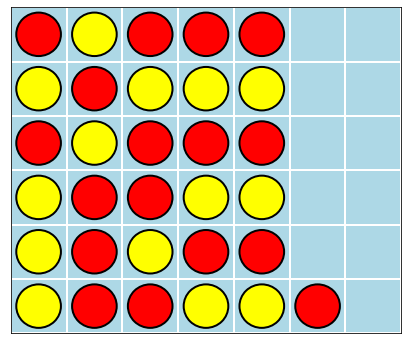

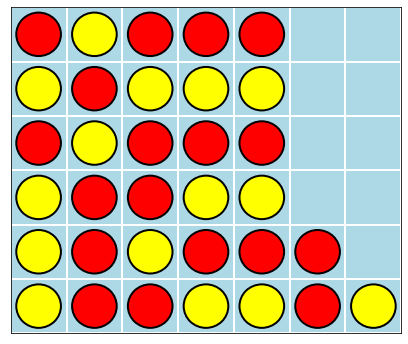

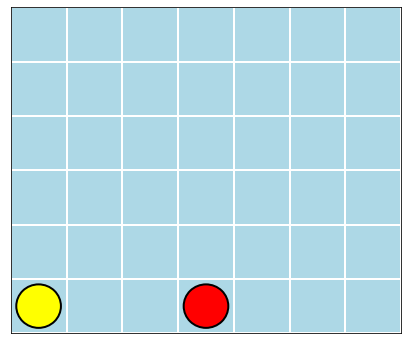

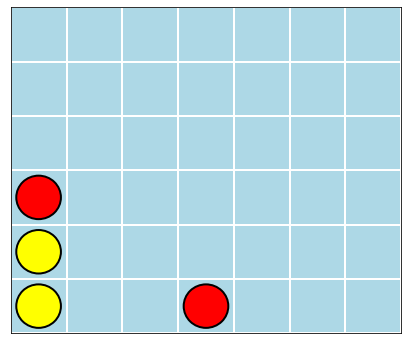

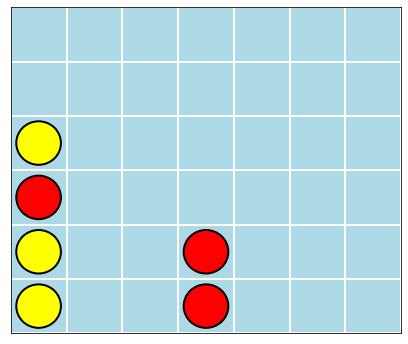

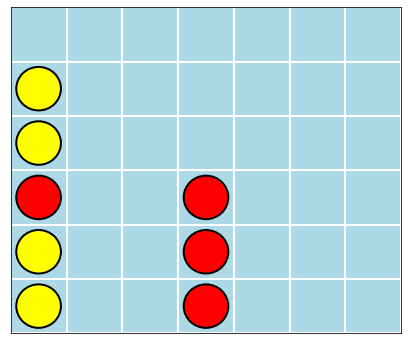

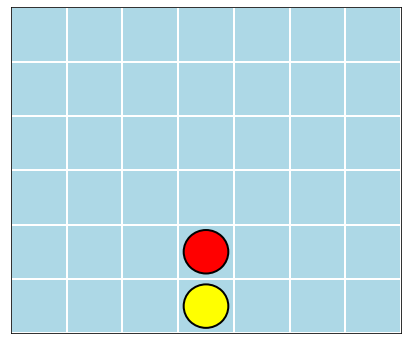

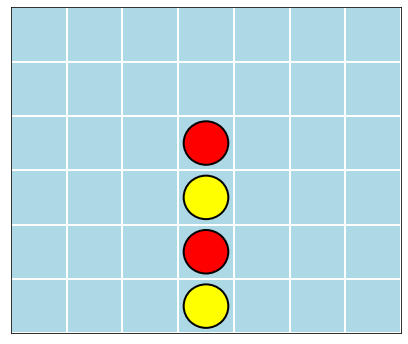

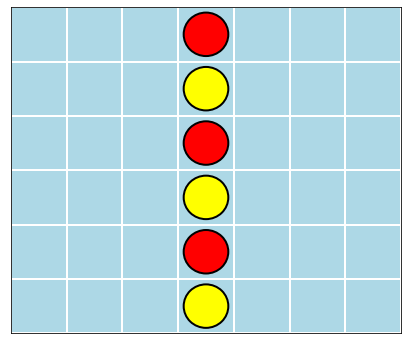

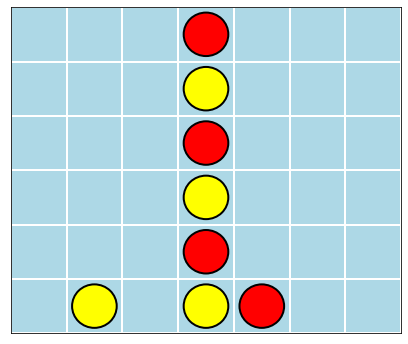

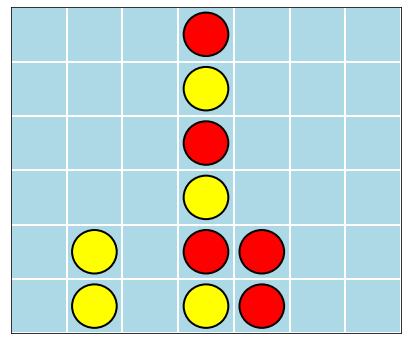

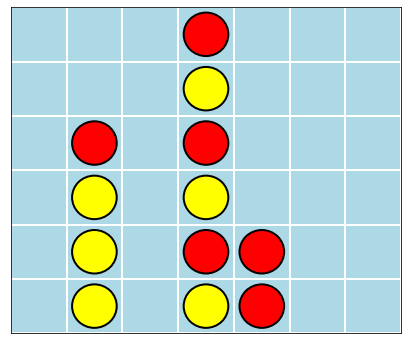

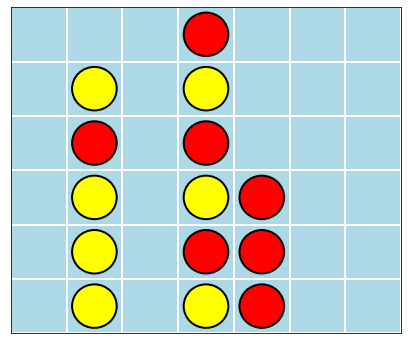

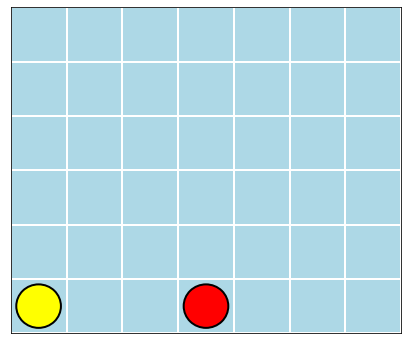

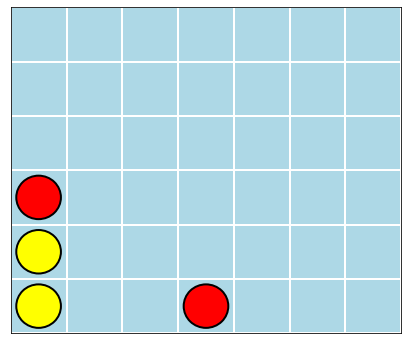

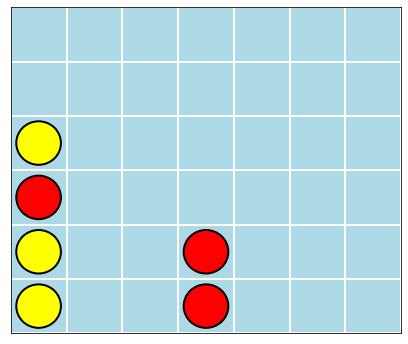

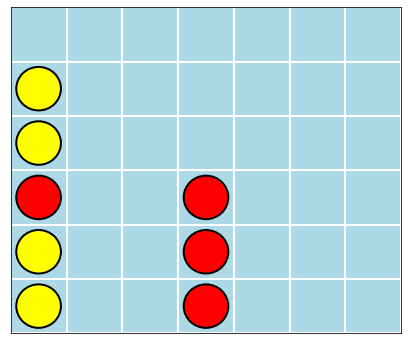

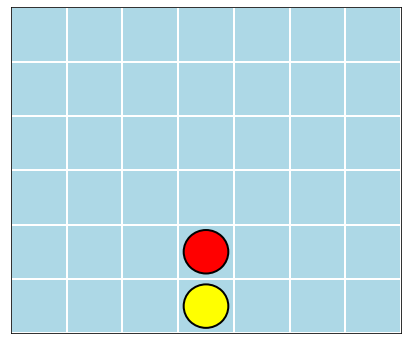

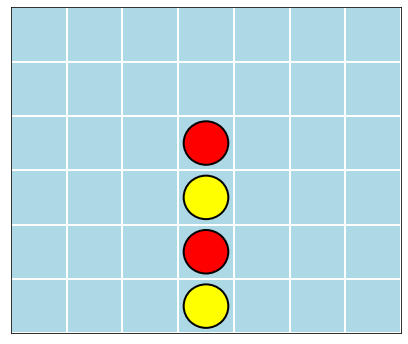

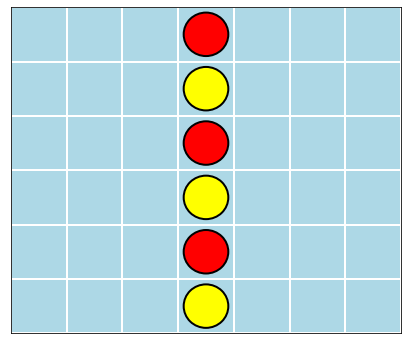

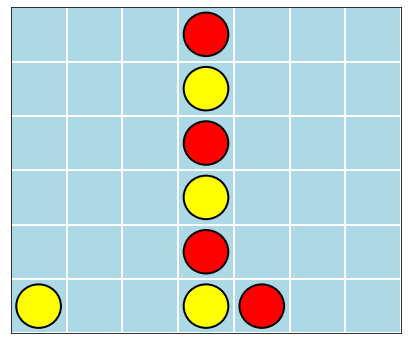

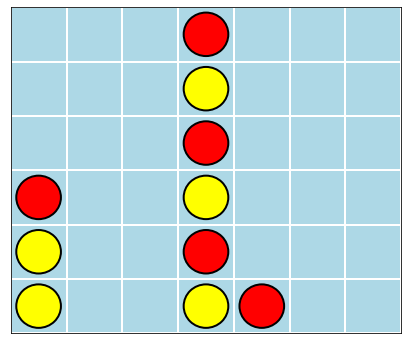

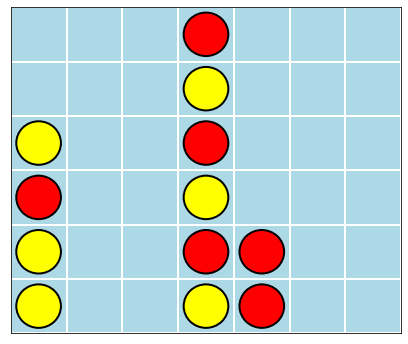

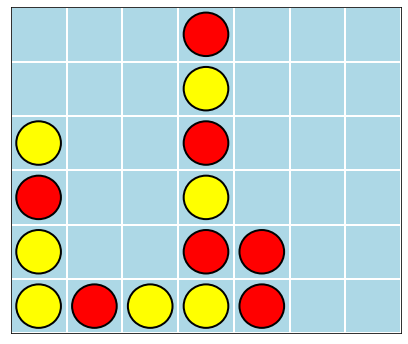

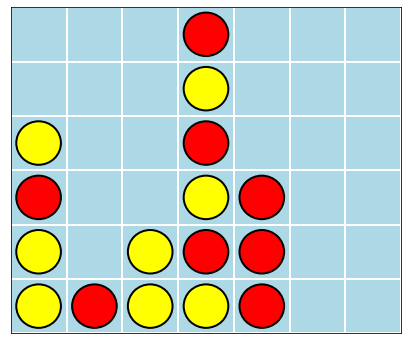

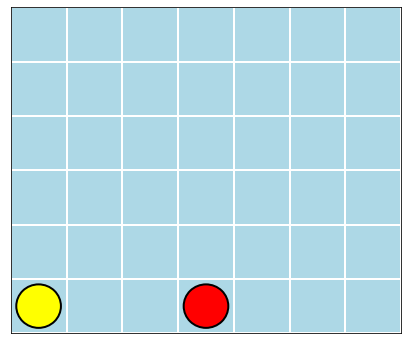

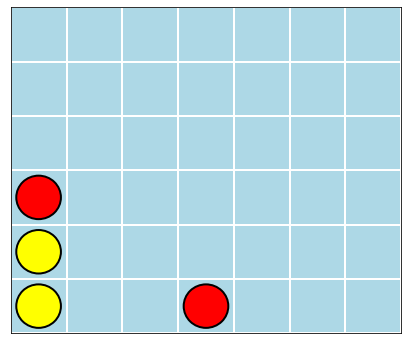

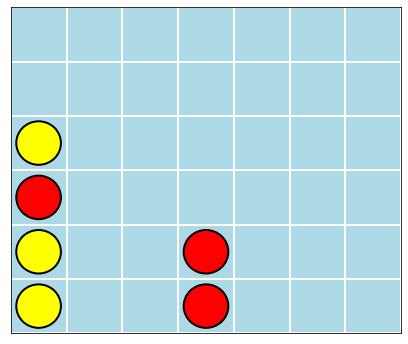

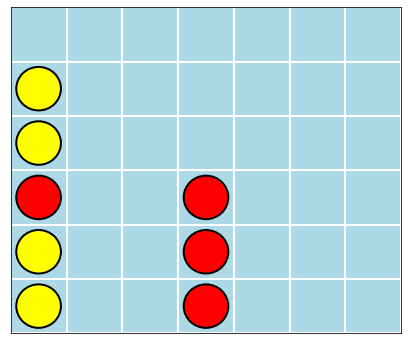

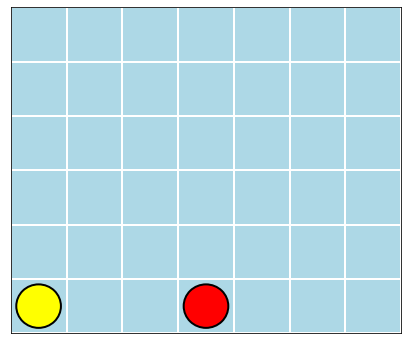

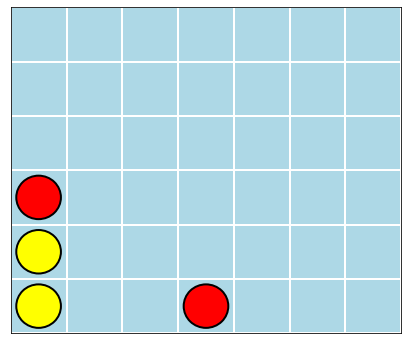

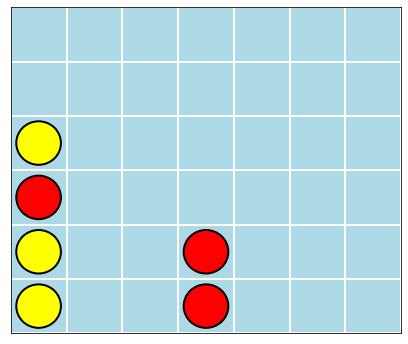

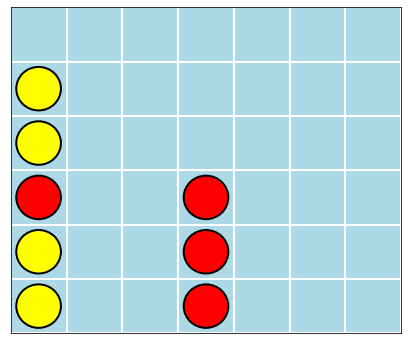

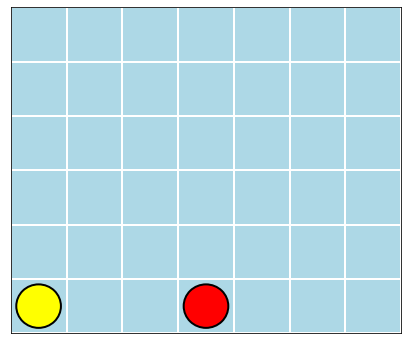

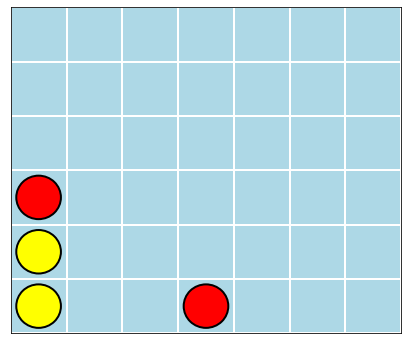

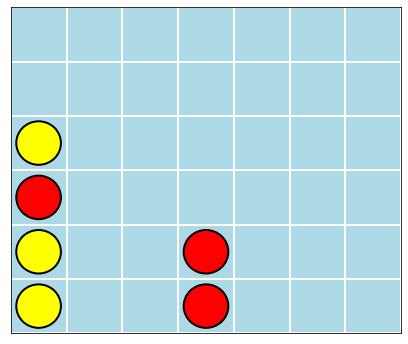

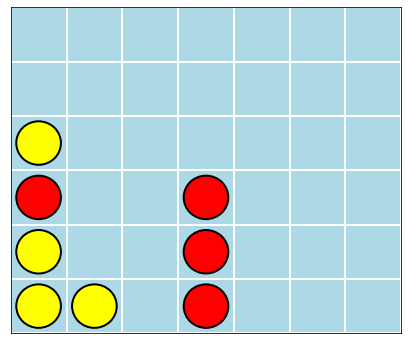

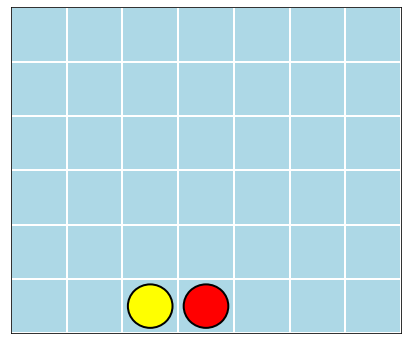

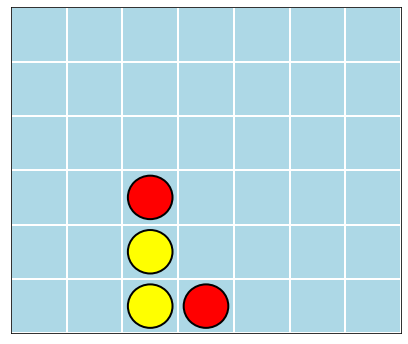

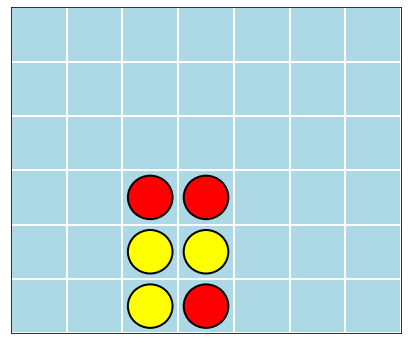

In [62]:
# This cell is supposed to evaluate the Decision Transformer against a MinimaxAgent (or RandomAgent) for a fixed amount of Episodes
model = model.to("cpu")
env = Env()
max_ep_len = max_episode_length
print(f"Maximum Episode Length is {max_ep_len}")
device = "cpu"
TARGET_RETURN = 1
NUM_EVAL = 100

opponent = MinimaxAgent(env, depth=2, epsilon=0, player=2)

games_won = 0
games_lost = 0

for ii in range(0,NUM_EVAL):

    state_dim = env.field.num_columns * env.field.num_rows
    act_dim = 7
    # Create the decision transformer model
    episode_return, episode_length = 0, 0
    env.reset()
    state = np.array(env.get_state()).flatten()
    target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
    states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)

    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    for t in range(max_ep_len):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        action = get_action(
            model,
            states,
            actions,
            rewards,
            target_return,
            timesteps,
        )
        actions[-1] = action
        action = action.detach().cpu().numpy()
        #print(f"Action chosen: {action}")
        action_taken = np.argmax(action)
        #print(action_taken)

        #state, reward, done, _ = env.step(action)
        # valid, reward, finished = env.step(int(action), AGENT)
        valid, reward, finished = env.step(int(action_taken), AGENT)
        #print(f"My reward: {reward}, move was valid: {valid}, is game finished: {finished}")
        #env.render_console()
        state = np.array(env.get_state()).flatten()
        #env.render_pretty()

        if finished != -1:
            if finished == 1:
                games_won += 1
            if finished == 2:
                games_lost += 1
            break
        opp_action = opponent.act(env.field)
        #print(f"Opponent Action: {opp_action}")
        #print(env.field.field)
        valid, _, finished = env.step(int(opp_action), OPPONENT)
        state = np.array(env.get_state()).flatten()

        cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        rewards[-1] = reward

        pred_return = target_return[0, -1] - reward
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

        episode_return += reward
        episode_length += 1

        if finished != -1:
            if finished == 1:
                games_won += 1
            if finished == 2:
                games_lost += 1
            break
    env.render_pretty()

print(f"Score: Agent {games_won} - {games_lost} Opponent. There were {NUM_EVAL - games_lost - games_won} Ties")
    #env.render_pretty()

In [ ]:
finished = -1
env = Env()
agent = MinimaxAgent(env, depth=4, epsilon=0, player=2)
opponent = MinimaxAgent(env, depth=4, epsilon=0, player=1)
mini_won = 0
mini_lost = 0
mini_tie = 0
for epi in range(0,1):
    finished = -1
    env.reset()
    while finished == -1:

        action = agent.act(env.field)
        valid, reward, finished = env.step(action, 2)
        env.render_pretty()


        if finished != -1:
            break

        action = opponent.act(env.field)
        #action = opponent.act(env.get_state())
        valid, reward, finished = env.step(action, 1)
        env.render_pretty()


        
    env.render_pretty()
    if finished == 1:
        mini_won+=1
    elif finished == 2:
        mini_lost += 1
    else: mini_tie += 1

print(f"Won {mini_won}, Lost: {mini_lost}, Tie: {mini_tie}")
    

